In [1]:
import pandas as pd
import ydata_profiling as pp
import sklearn
from matplotlib import pyplot
import numpy as np
from numpy import mean
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
import time
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv("train.csv")


In [3]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [4]:
numeric_mean = df.select_dtypes(include=np.number).mean()
df.fillna(numeric_mean, inplace=True)


In [5]:
X = df.drop(columns=['hospital_death'])
y = df['hospital_death']
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=2)


In [6]:
# dt_model = DecisionTreeClassifier(max_depth=5)  
# sfs = SequentialFeatureSelector(dt_model, direction='forward',n_features_to_select=5, scoring='roc_auc')
# X = df_onehot.loc[:, df_onehot.columns != 'hospital_death']
# y = df_onehot[['hospital_death']]
# sfs.fit(X, y)
# print(sfs.get_feature_names_out())


# Perform Sequential Feature Selection (SFS)
# sfs = SequentialFeatureSelector(
#     dt_model, direction="forward", n_features_to_select=20, scoring="roc_auc"
# )
# sfs.fit(X, y)
# selected_features = sfs.get_feature_names_out()

# Print the selected features
# print("Selected Features:", selected_features)

In [7]:
selected_features = [
    'gcs_motor_apache', 'gcs_verbal_apache', 'intubated_apache',
    'ventilated_apache', 'd1_resprate_max', 'd1_sysbp_min',
    'd1_sysbp_noninvasive_min', 'h1_spo2_max', 'apache_4a_hospital_death_prob',
    'solid_tumor_with_metastasis', 'icu_type_CSICU', 'icu_type_Neuro ICU',
    'icu_type_SICU', 'apache_3j_bodysystem_Gastrointestinal',
    'apache_2_bodysystem_Undefined Diagnoses'
]


# Selected Features: ['gcs_motor_apache' 'gcs_unable_apache' 'gcs_verbal_apache'
#  'intubated_apache' 'ventilated_apache' 'd1_resprate_max' 'd1_sysbp_min'
#  'd1_sysbp_noninvasive_min' 'h1_spo2_max' 'apache_4a_hospital_death_prob'
#  'ethnicity_Asian' 'gender_M' 'icu_stay_type_readmit' 'icu_type_CSICU'
#  'icu_type_SICU' 'apache_3j_bodysystem_Musculoskeletal/Skin'
#  'apache_3j_bodysystem_Sepsis' 'apache_2_bodysystem_Gastrointestinal'
#  'apache_2_bodysystem_Renal/Genitourinary'
#  'apache_2_bodysystem_Undefined diagnoses']


trainX = trainX[selected_features]
testX= testX[selected_features]


In [8]:
def fit_model(model, model_name):
    model.fit(trainX,trainy)
    md_probs = model.predict_proba(testX)
    md_probs = md_probs[:,1]
    md_auc = roc_auc_score(testy, md_probs)
    print(model_name, " : ", md_auc)
    md_fpr, md_tpr, _ = roc_curve(testy, md_probs)
    pyplot.plot(md_fpr, md_tpr, marker='.', label=model_name)
    # return (md_fpr, md_tpr)

Depth 5 Split 2  :  0.8561012354644256
Depth 7 Split 2  :  0.8543722077776202
Depth 5 Split 5  :  0.8561012354644256
Depth 7 Split 5  :  0.8550381616883859


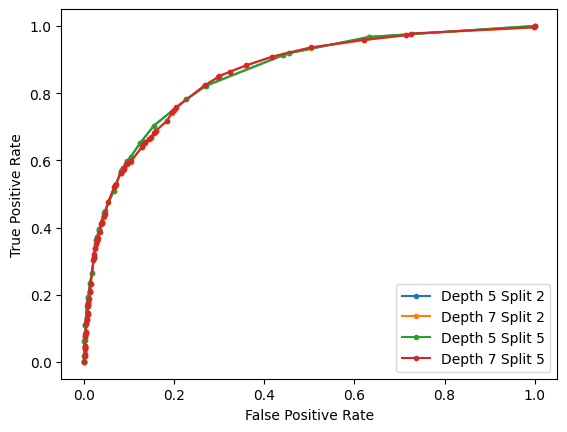

In [9]:
dt_5_2 = DecisionTreeClassifier(max_depth=5)  
fit_model(dt_5_2, "Depth 5 Split 2") 

dt_7_2 = DecisionTreeClassifier(max_depth=7)  
fit_model(dt_7_2, "Depth 7 Split 2") 

dt_5_5 = DecisionTreeClassifier(max_depth=5, min_samples_split=5)  
fit_model(dt_5_5, "Depth 5 Split 5") 

dt_7_5 = DecisionTreeClassifier(max_depth=7, min_samples_split=5)  
fit_model(dt_7_5, "Depth 7 Split 5") 


pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [10]:
def fitting_models_CV2():
    cv = RepeatedKFold(n_splits=10, n_repeats=2)#, random_state=1)
    
    dt_5_2 = DecisionTreeClassifier(max_depth=5)  
    dt_7_2 = DecisionTreeClassifier(max_depth=7)  
    dt_5_5 = DecisionTreeClassifier(max_depth=5, min_samples_split=5)  
    dt_7_5 = DecisionTreeClassifier(max_depth=7, min_samples_split=5)  
    #kn = KNeighborsClassifier(n_neighbors=5)
    #pipe_kn = Pipeline([("scaler", MinMaxScaler()), 
    #                     ("knr", KNeighborsClassifier(n_neighbors=5))])
    clfs = [('Depth 5 Split 2', dt_5_2),        
        ('Depth 7 Split 2', dt_7_2),        
        ('Depth 5 Split 5', dt_5_5),
        ('Depth 7 Split 5', dt_7_5)
        #('KNearest Neighbor',kn),
        #('Scaled KNearest',pipe_kn)       
    ]
    for name,clf in clfs:
        start = time.perf_counter()
        #scores = cross_val_score(clf, X, y, scoring="accuracy", cv=cv) 
        scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=cv, n_jobs=-1) 
        end = time.perf_counter()        
        score = format(mean(scores), '.4f')
        duration = format((end-start),'.4f')
        print("{} : {} - {}".format(name,score,duration))

In [11]:
fitting_models_CV2()

Depth 5 Split 2 : 0.8437 - 2.7731


KeyboardInterrupt: 

In [ ]:
parameters = {     
                'min_samples_split' : [2,3,4,5,6,7,8,9,10],#,400],
                'max_depth'    : [3,4,5,6,7,8,9,10],
                
                }
dt = DecisionTreeClassifier()
cv = RepeatedKFold(n_splits=10, n_repeats=1)#, random_state=1)
grid_search = GridSearchCV(dt, parameters, cv=cv, n_jobs=-1, scoring='roc_auc',verbose=2)#, refit=False)
grid_search.fit(X, y)
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=3; total time=   0.3s
[CV] END ...................max_depth=3, min_samples_split=2; total time=   0.3s
[CV] END ...................max_depth=3, min_s